# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import data_visualisation as dv
from wfdb import processing

import os

# Load ECGs

In [2]:
import re

def extract_int_from_filename(filename):
    # Use a regular expression to find digits in the filename
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        raise ValueError("No integer found in the filename.")

# Example usage
filename = 'BRS 9a.txt'
extracted_number = extract_int_from_filename(filename)
print(f"Extracted number: {extracted_number}")

Extracted number: 9


In [3]:
def load_ecg(file_path):
    # Read
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize the variable to store samples per channel
    samples_per_channel = 0

    # Parse the header to find the "Samples per channel"
    for line in lines:
        if "Samples per channel" in line:
            samples_per_channel = int(line.split(':')[1].strip())
            break
        
        
    # Find the start of the data section
    data_start_idx = 0
    for i, line in enumerate(lines):
        if '[Data]' in line:
            data_start_idx = i + 1
            break
    
    # Extract the data lines
    data_lines = lines[data_start_idx:]
    
    # Parse the data lines into a list of integers
    data = []
    for line in data_lines:
        # Split line by commas and convert to integers
        leads = [int(x) for x in line.split(',') if x.strip() != '']
        leads = leads[:12]
        data.extend(leads)
        
    # format the data into a numpy array
    ecg = np.array(data).reshape(-1, 12)
    truncated_length = (ecg.shape[0] // 1000) * 1000
    truncated_ecg = ecg[:truncated_length]

    ## Downsample to 100hz
    ecg = truncated_ecg.reshape(-1, 10, 12).mean(axis=1)
    # ecg = truncated_ecg.reshape((truncated_length // 10), 12, 10)
    # ecg = np.mean(ecg, axis=2)
    
    return ecg

In [4]:
# get all files in the directory

ecgs = []
patients = []
files = []

for file in os.listdir("BARD"):
    if file.endswith(".txt"):
        ecg = load_ecg("BARD/" + file)
        ecgs.append(ecg)
        patients.append(extract_int_from_filename(file))
        files.append(file)

print(len(ecgs))


717


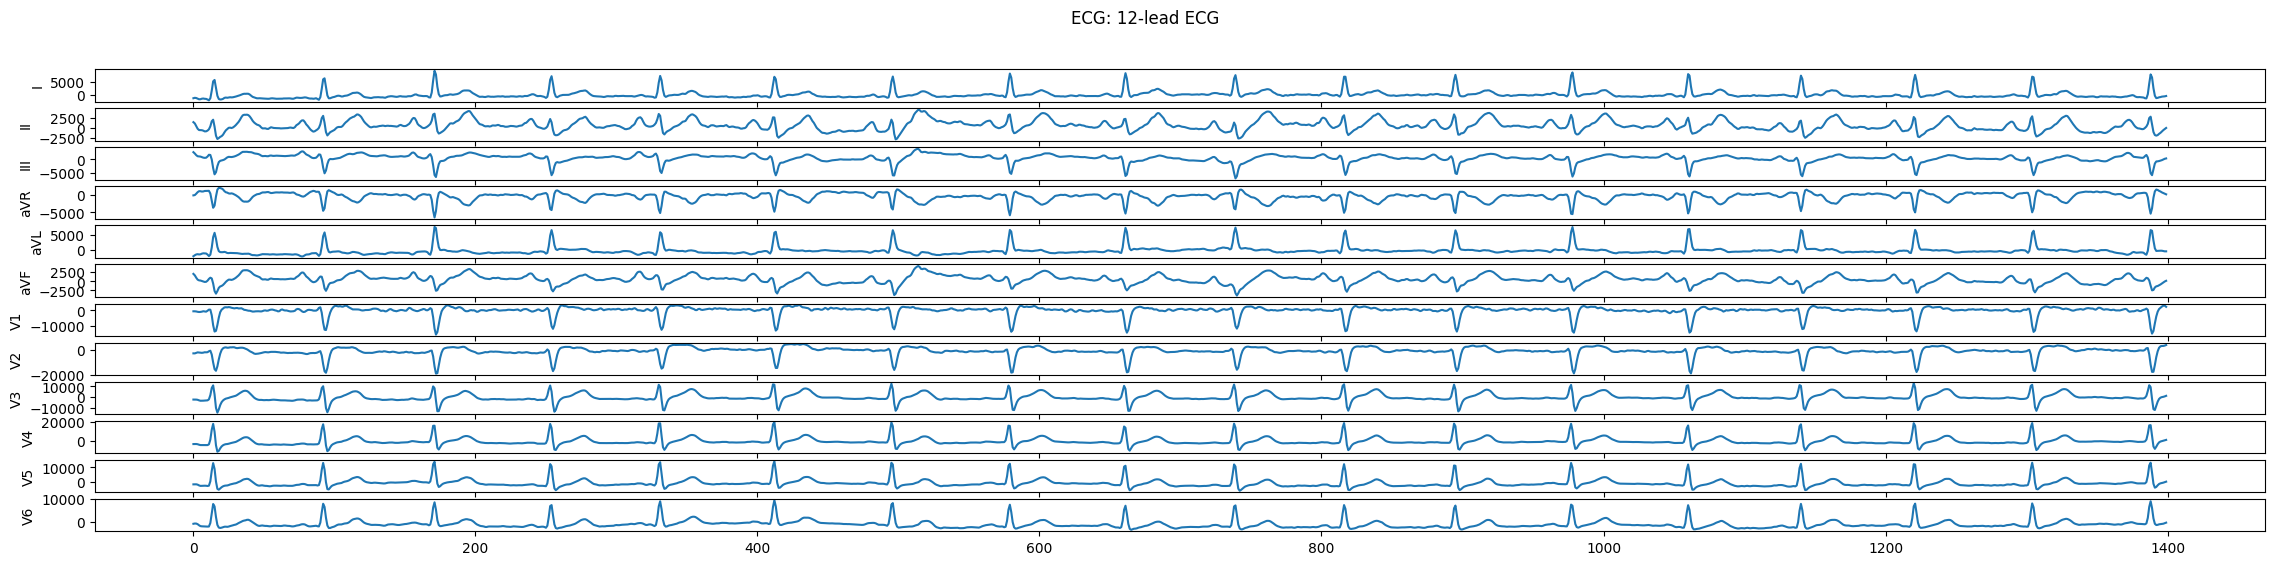

In [5]:
ecg_b = load_ecg("BARD/BRS 3h.txt")
dv.plot_12_lead_ecg(ecg_b, "12-lead ECG")

# Normalize ECGs

In [6]:
# Normalise data
from sklearn.preprocessing import StandardScaler

ecgs_norm = []

scaler = StandardScaler()
scaler.fit(np.concatenate(ecgs))
for i in range(len(ecgs)):
    # ecgs[i] = scaler.transform(ecgs[i])
    ecgs_norm.append(scaler.transform(ecgs[i]))
    

# Visaulaize ECGs

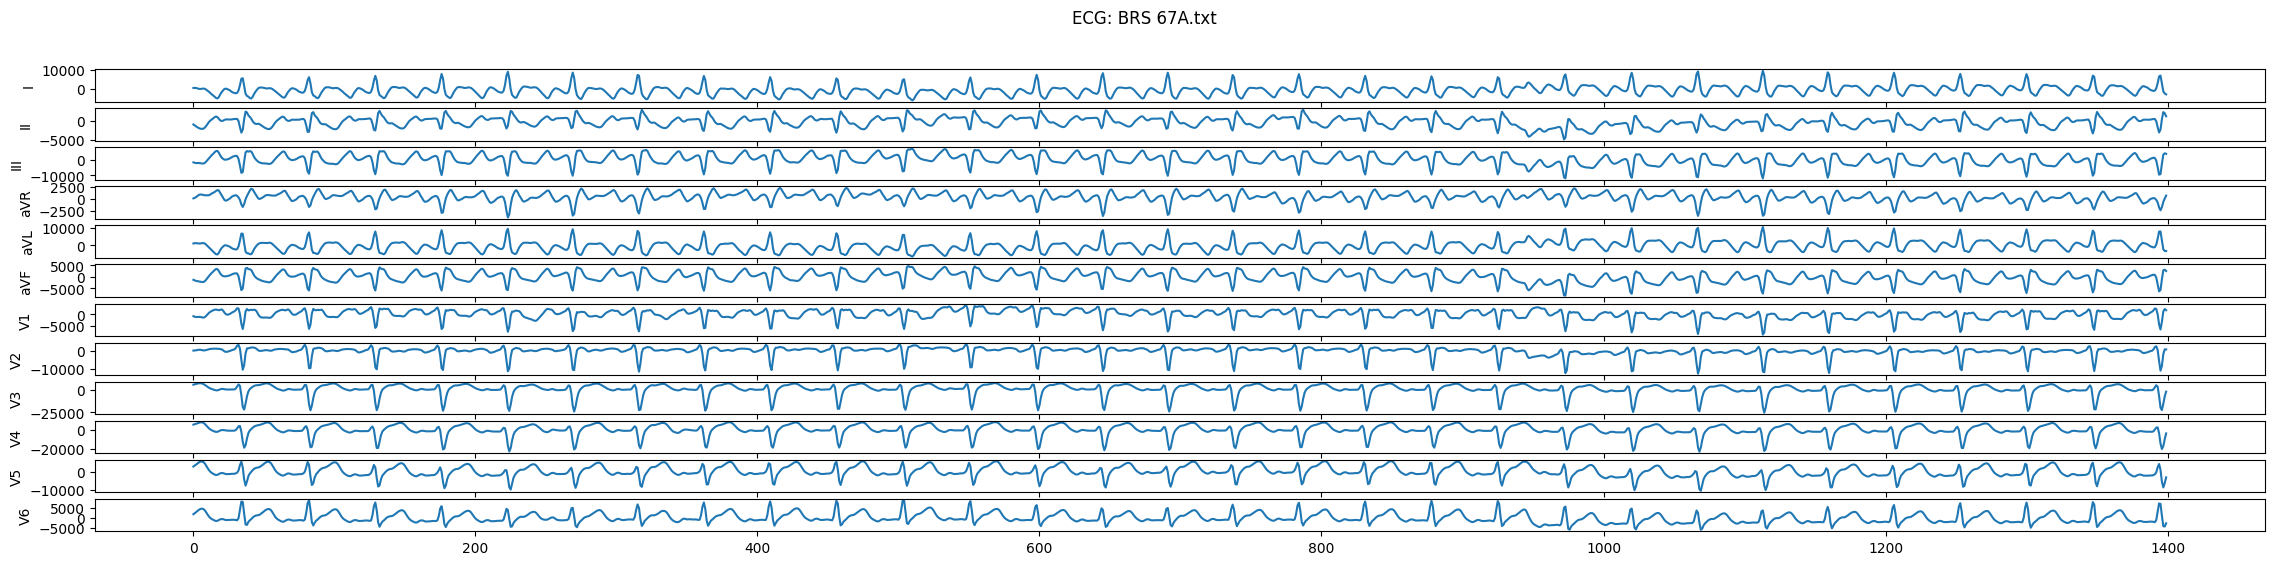

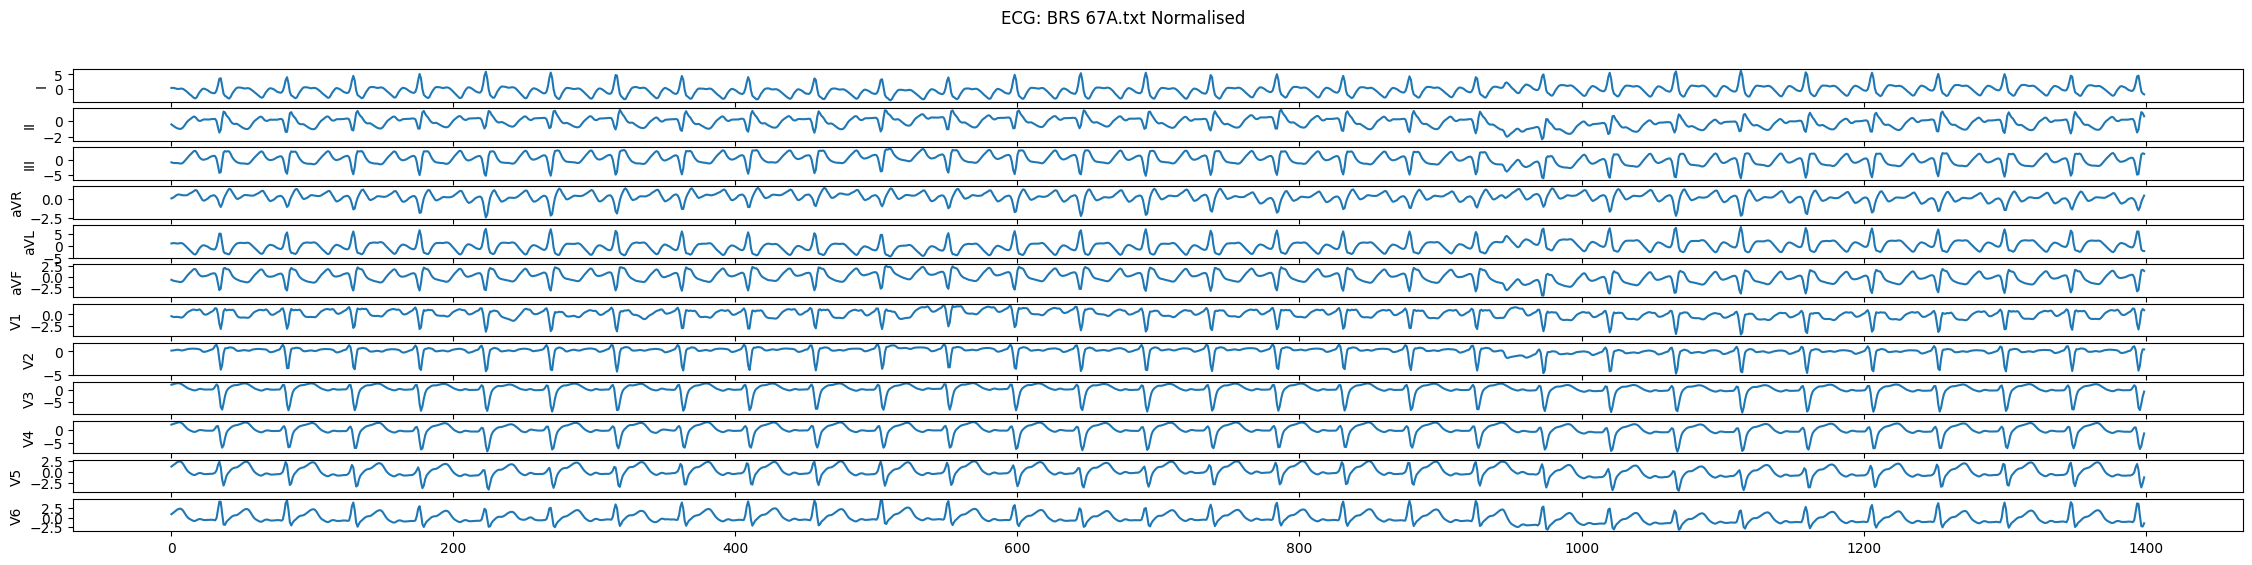

In [7]:
# get a random ecg
random_idx = np.random.randint(len(ecgs))
ecg = ecgs[random_idx]
ecg_n = ecgs_norm[random_idx]
file = files[random_idx]
dv.plot_12_lead_ecg(ecg, f'{file}')
dv.plot_12_lead_ecg(ecg_n, f'{file} Normalised')

# Split ECGs into beats

In [10]:
def split_into_beats(X, folds=None, window_size=50):
    ecgs_HB = []
    ecgs_HB_patients = []
    ecgs_HB_samples = []
    
    for i, sample in enumerate(X):
        print("Progress:", i, "/", X.shape[0], end="\r")
        xqrs = processing.XQRS(sig=sample[:,0], fs=100)
        xqrs.detect(verbose=False)
        qrs_inds = xqrs.qrs_inds
        for indx in qrs_inds:
            if indx + window_size > sample.shape[0] or indx - window_size < 0:
                continue
            ecgs_HB.append(sample[indx-window_size:indx+window_size])
            ecgs_HB_patients.append(patients[i])
            ecgs_HB_samples.append(i)
    
    return np.array(ecgs_HB), np.array(ecgs_HB_patients), np.array(ecgs_HB_samples)

ecgs_HB, ecgs_HB_patients, ecgs_HB_samples = split_into_beats(np.array(ecgs))

/tmp/ipykernel_5610/1795360791.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecgs_HB, ecgs_HB_patients, ecgs_HB_samples = split_into_beats(np.array(ecgs))


(100, 12)


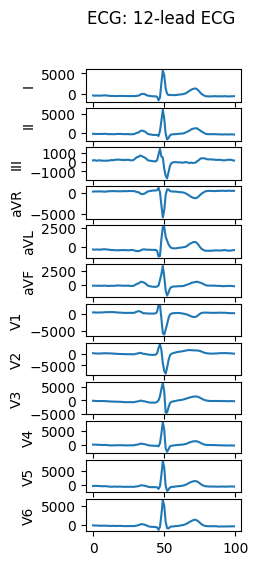

In [12]:
random_i = np.random.randint(0, ecgs_HB.shape[0])
random_ecg = ecgs_HB[random_i]
print(random_ecg.shape)
dv.plot_12_lead_ecg(random_ecg, '12-lead ECG')

In [13]:
# save
NP_PATH = "data/BARD.npz"


ecgs = np.array(ecgs)
print(ecgs.shape)

save_args = {
    "ecgs": ecgs,
    "ecgs_HB": ecgs_HB,
    "ecgs_HB_patients": ecgs_HB_patients,
    "ecgs_HB_samples": ecgs_HB_samples,
}

np.savez(NP_PATH, **save_args)

/tmp/ipykernel_5610/2037253985.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecgs = np.array(ecgs)


(717,)


(717,) (14751, 100, 12) (14751,) (14751,)
(1400, 12)


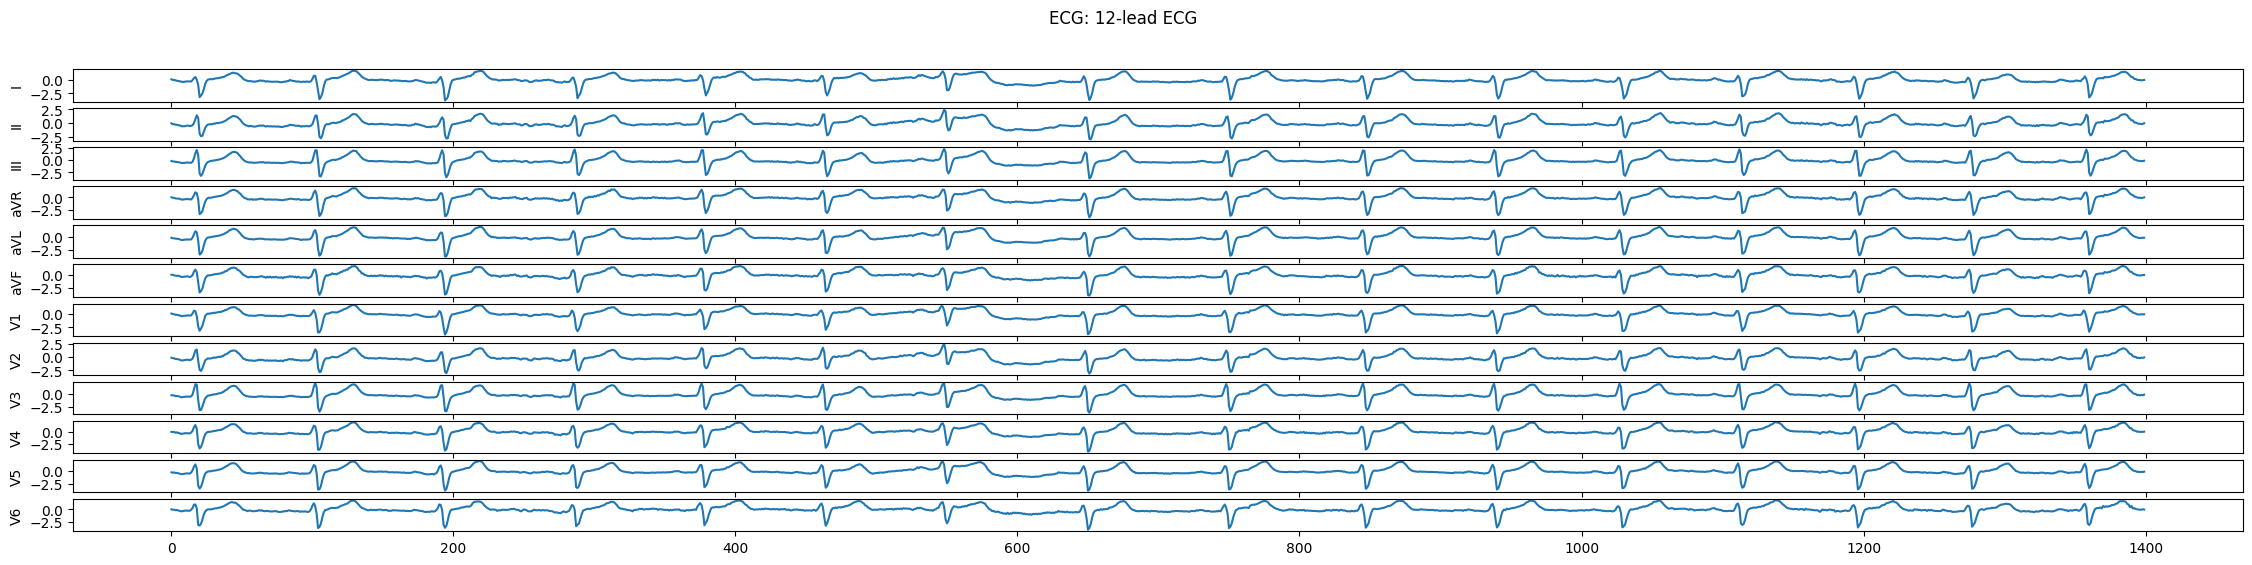

(100, 12)


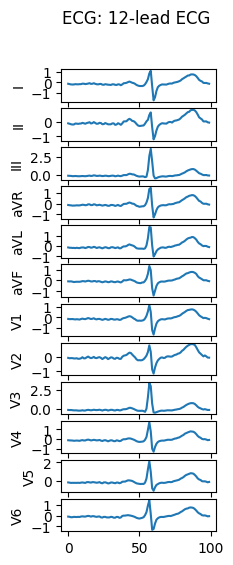

In [8]:
# load Data
import sys
thismodule = sys.modules[__name__]

with np.load('data/BARD.npz', allow_pickle=True) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k])
            
print(ecgs.shape, ecgs_HB.shape, ecgs_HB_patients.shape, ecgs_HB_samples.shape)

# get a random ecg
ecg = np.random.choice(ecgs)
print(ecg.shape)
dv.plot_12_lead_ecg(ecg, '12-lead ECG')

# get a random hb
random_i = np.random.randint(0, ecgs_HB.shape[0])
ecg = ecgs_HB[random_i]
print(ecg.shape)
dv.plot_12_lead_ecg(ecg, '12-lead ECG')